In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm  # For progress bars
import matplotlib.pyplot as plt  # For visualization

2025-05-15 17:33:09.993172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747330390.206085      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747330390.266954      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Constants configuration
BASE_PATH = '/kaggle/input/multimodal-iris-fingerprint-biometric-data/IRIS and FINGERPRINT DATASET'
NUM_PEOPLE = 45  # Number of individuals in dataset
FINGERPRINT_SHAPE = (128, 128, 3)  # Fingerprint dimensions (RGB)
IRIS_SHAPE = (64, 64, 1)  # Iris dimensions (grayscale)
BATCH_SIZE = 8  # Training batch size
EPOCHS = 50  # Number of training epochs

In [4]:
def load_image(person_path, modality, size, grayscale=False):
    """
    Load and preprocess a single image for a given modality.
    
    Args:
        person_path: Path to person's directory
        modality: 'Fingerprint', 'left', or 'right'
        size: Target image dimensions (height, width)
        grayscale: Whether to load as grayscale
    
    Returns:
        Preprocessed image array or None if not found
    """
    modality_path = os.path.join(person_path, modality)
    if not os.path.exists(modality_path):
        return None
    
    # Find first available BMP image in directory
    files = [f for f in os.listdir(modality_path) if f.endswith(('.bmp', '.BMP'))]
    if not files:
        return None
    
    # Load image with specified color mode
    color_mode = 'grayscale' if grayscale else 'rgb'
    img = load_img(
        os.path.join(modality_path, files[0]),
        color_mode=color_mode,
        target_size=size
    )
    return img_to_array(img)

In [5]:
def load_all_data(base_path, num_people):
    """
    Load and preprocess all biometric data from dataset.
    
    Args:
        base_path: Root directory of dataset
        num_people: Number of individuals to load
    
    Returns:
        Tuple of (fingerprint_data, left_iris_data, right_iris_data, labels)
    """
    finger_images, left_iris_images, right_iris_images, labels = [], [], [], []
    
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Dataset path does not exist: {base_path}")
    
    print("Loading data...")
    for person_id in tqdm(range(1, num_people + 1), desc="Processing persons"):
        person_path = os.path.join(base_path, str(person_id))
        if not os.path.exists(person_path):
            print(f"Warning: Directory for person {person_id} does not exist. Skipping.")
            continue
        
        # Load fingerprint image
        finger_img = load_image(person_path, 'Fingerprint', FINGERPRINT_SHAPE[:2], grayscale=False)
        if finger_img is None:
            print(f"Warning: No fingerprint image for person {person_id}. Skipping.")
            continue
        
        # Load iris images
        left_img = load_image(person_path, 'left', IRIS_SHAPE[:2], grayscale=True)
        right_img = load_image(person_path, 'right', IRIS_SHAPE[:2], grayscale=True)
        if left_img is None or right_img is None:
            print(f"Warning: Missing iris images for person {person_id}. Skipping.")
            continue
        
        # Store collected data
        finger_images.append(finger_img)
        left_iris_images.append(left_img)
        right_iris_images.append(right_img)
        labels.append(person_id - 1)  # Zero-based indexing
    
    if len(labels) == 0:
        raise ValueError("No data was loaded. Check your dataset path or file structure.")
    
    return np.array(finger_images), np.array(left_iris_images), np.array(right_iris_images), np.array(labels)

In [6]:
def create_iris_branch(input_shape, name_prefix=""):
    """
    Create a CNN branch for processing iris images.
    
    Args:
        input_shape: Shape of input iris images
        name_prefix: Prefix for layer names
    
    Returns:
        Keras Model for iris processing
    """
    inputs = layers.Input(shape=input_shape, name=f"{name_prefix}_input")
    
    # Convolutional layers for feature extraction
    x = layers.Conv2D(16, (3, 3), activation='relu', name=f"{name_prefix}_conv1")(inputs)
    x = layers.MaxPooling2D(name=f"{name_prefix}_pool1")(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', name=f"{name_prefix}_conv2")(x)
    x = layers.MaxPooling2D(name=f"{name_prefix}_pool2")(x)
    x = layers.GlobalAveragePooling2D(name=f"{name_prefix}_gap")(x)
    
    return Model(inputs, x, name=f"{name_prefix}_branch")

In [7]:
def create_multimodal_model(finger_shape, iris_shape, num_classes):
    """
    Create the complete multimodal biometric model.
    
    Args:
        finger_shape: Shape of fingerprint images
        iris_shape: Shape of iris images
        num_classes: Number of individuals to classify
    
    Returns:
        Compiled Keras Model
    """
    # ======================
    # Fingerprint Branch
    # ======================
    # Use MobileNetV2 as feature extractor (pretrained on ImageNet)
    base_model = MobileNetV2(
        input_shape=finger_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False  # Freeze pretrained weights
    
    # ======================
    # Iris Branches
    # ======================
    # Shared iris processing model (same weights for left/right)
    iris_processor = create_iris_branch(iris_shape)
    
    # Input layers for each modality
    fingerprint_input = layers.Input(shape=finger_shape, name="fingerprint_input")
    left_iris_input = layers.Input(shape=iris_shape, name="left_iris_input")
    right_iris_input = layers.Input(shape=iris_shape, name="right_iris_input")
    
    # Process each modality
    fingerprint_features = base_model(fingerprint_input)
    left_iris_features = iris_processor(left_iris_input)
    right_iris_features = iris_processor(right_iris_input)
    
    # ======================
    # Feature Fusion
    # ======================
    # Combine all features
    combined = layers.Concatenate(name="feature_concat")([
        fingerprint_features,
        left_iris_features,
        right_iris_features
    ])
    
    # ======================
    # Classification Head
    # ======================
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create complete model
    model = Model(
        inputs=[fingerprint_input, left_iris_input, right_iris_input],
        outputs=output,
        name="multimodal_biometric_model"
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    
    Args:
        history: Keras training history object
    """
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
def main():
    # Load and preprocess data
    finger_data, left_iris_data, right_iris_data, labels = load_all_data(BASE_PATH, NUM_PEOPLE)
    
    # Convert and normalize fingerprint data
    if finger_data.shape[-1] == 1:  # If grayscale
        finger_data_rgb = np.repeat(finger_data, 3, axis=-1) / 255.0
    else:
        finger_data_rgb = finger_data / 255.0
    
    # Normalize iris data
    left_iris_data = left_iris_data / 255.0
    right_iris_data = right_iris_data / 255.0
    
    # Print dataset information
    print("\nDataset Information:")
    print(f"Number of samples: {len(labels)}")
    print(f"Fingerprint shape: {finger_data_rgb.shape}")
    print(f"Left iris shape: {left_iris_data.shape}")
    print(f"Right iris shape: {right_iris_data.shape}")
    
    # Convert labels to one-hot encoding
    num_classes = len(np.unique(labels))
    y = tf.keras.utils.to_categorical(labels, num_classes)
    
    # Create and train model
    print("\nCreating multimodal model...")
    model = create_multimodal_model(FINGERPRINT_SHAPE, IRIS_SHAPE, num_classes)
    model.summary()  # Print model architecture
    
    print("\nTraining model...")
    history = model.fit(
        [finger_data_rgb, left_iris_data, right_iris_data],
        y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1
    )
    
    # Visualize training progress
    plot_training_history(history)

Loading data...


Processing persons: 100%|██████████| 45/45 [00:01<00:00, 42.23it/s]



Dataset Information:
Number of samples: 45
Fingerprint shape: (45, 128, 128, 3)
Left iris shape: (45, 64, 64, 1)
Right iris shape: (45, 64, 64, 1)

Creating multimodal model...


I0000 00:00:1747330404.374651      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747330404.375354      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "multimodal_biometric_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ fingerprint_input         │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ left_iris_input           │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ right_iris_input          │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_128      │ (None, 1280)           │      2,257,984 │ fingerprint_input[0][… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ _branch (Functional)      │ (None, 32)             │          4,800 │ left_iris_input[0][0], │
│                           │                        │                │ right_iris_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_concat            │ (None, 1344)           │              0 │ mobilenetv2_1.00_128[… │
│ (Concatenate)             │                        │                │ _branch[0][0],         │
│                           │                        │                │ _branch[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        172,160 │ feature_concat[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 45)             │          5,805 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,440,749 (9.31 MB)

 Trainable params: 182,765 (713.93 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Training model...
Epoch 1/50


I0000 00:00:1747330414.373950      62 service.cc:148] XLA service 0x7b7e58004260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747330414.374979      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747330414.375001      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747330415.361036      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0683 - loss: 6.9593 

I0000 00:00:1747330420.561723      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 909ms/step - accuracy: 0.0615 - loss: 6.9774
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0288 - loss: 6.9919
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 6.7693
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0293 - loss: 6.4130    
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0764 - loss: 5.9919
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0203 - loss: 6.3620    
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0203 - loss: 6.2932    
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0535 - loss: 5.8705
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0226 - loss: 5.9976     
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1210 - loss: 5.6669 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1081 - loss: 5.7687 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1332 - loss

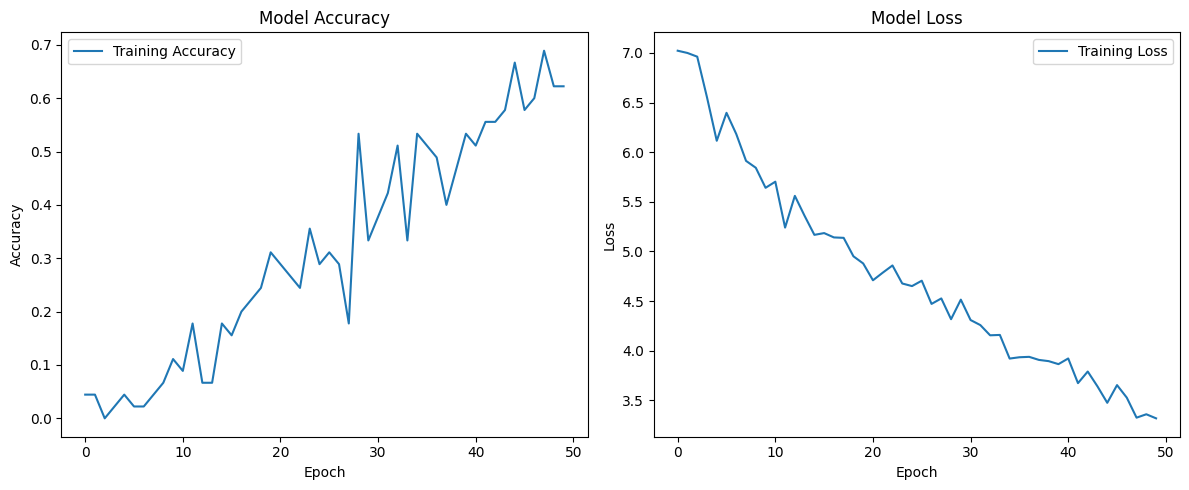

In [10]:
if __name__ == "__main__":
    main()